# Electron Cooling

In [1]:
%load_ext autoreload

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

from astropy.io import fits


np.set_printoptions(threshold=np.nan)


import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

## Set Up Abscissa for Testing

In [4]:
mwimp = 1e12
neng = 500
dlneng = np.log(mwimp)/neng
elecbins = np.exp(np.arange(neng+1)*dlneng)
englow = elecbins[0:neng]
enghigh = elecbins[1:]
eleceng = np.sqrt(englow*enghigh)

nphoteng = 500
dlnphoteng = np.log(mwimp/1e-2)/nphoteng
photenglow = 1e-2*np.exp(np.arange(nphoteng)*dlnphoteng)
photenghigh = 1e-2*np.exp((np.arange(nphoteng)+1)*dlnphoteng)
photeng = np.sqrt(photenglow*photenghigh)

T = phys.TCMB(1000)

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

sec_elec_tf = copy.deepcopy(engloss_tf)

for in_eng, spec in zip(sec_elec_tf.get_in_eng(), sec_elec_tf):
    spec.engloss_rebin(in_eng, sec_elec_tf.get_in_eng())

In [5]:
loweng = 250
eleceng_high = eleceng[eleceng > loweng]
eleceng_high_ind = np.arange(eleceng.size)[eleceng > loweng]

sec_phot_tf = tf.TransFuncAtRedshift([], dlnz=-1, rs=ICS_tf.rs)
sec_lowengelec_tf = tf.TransFuncAtRedshift([], dlnz=-1, rs=ICS_tf.rs)
cont_loss_vec = np.zeros_like(eleceng)
deposited_vec = np.zeros_like(eleceng)
ICS_tf_high = tf.TransFuncAtRedshift(
    ICS_tf[eleceng_high_ind[0]:], dlnz=-1, rs=ICS_tf.rs
)

delta_spec = np.zeros_like(eleceng)
for i,eng in zip(np.arange(eleceng.size), eleceng):
    delta_spec *= 0
    delta_spec[i] = 1
    if i < eleceng_high_ind[0]:
        sec_phot_N = np.zeros_like(photeng)
        sec_elec_N = delta_spec
    else:
        sec_phot_N = spectools.scatter(
            ICS_tf, mode='N', out_mode='N',
            eng_arr = eleceng, N_arr = delta_spec, new_eng = photeng
        )
        sec_elec_N = spectools.scatter(
            sec_elec_tf, mode='N', out_mode='N',
            eng_arr = eleceng, N_arr = delta_spec, new_eng = eleceng
        )
    # Continuum loss
    continuum_engloss = -phys.thomson_xsec*phys.c*phys.CMB_eng_density(T)
    # Total number of primaries
    pri_elec_totN = np.sum(sec_elec_N)
    # Total energy loss
    pri_elec_totengloss = pri_elec_totN*eng - np.sum(sec_elec_N*eleceng)
    # 'Deposited' energy
    deposited_eng = pri_elec_totengloss - (np.sum(sec_phot_N*photeng) + continuum_engloss)

    if eng > loweng:
        # Normalize all quantities to one scattering. 
        sec_phot_N /= pri_elec_totN
        sec_elec_N /= pri_elec_totN
        continuum_engloss /= pri_elec_totN
        deposited_eng /= pri_elec_totN
        # total number of electrons in sec_elec_N is now 1. 
        # remove the self-scattering bin, re-scale the energy. 
        fac = 1 - sec_elec_N[i]*eleceng[i]/(np.sum(sec_elec_N)*eng)
        sec_elec_N[i] = 0
        sec_phot_N /= fac
        sec_elec_N /= fac
        continuum_engloss /= fac
        deposited_eng /= fac
        scattered_elec_N = sec_elec_N[0:i]
        resolved_lowengelec_spec_N = spectools.scatter(
            sec_lowengelec_tf, mode='N', out_mode='N',
            eng_arr = eleceng[0:i], N_arr = scattered_elec_N,
            new_eng = eleceng
        )
        resolved_phot_spec_N = spectools.scatter(
            sec_phot_tf, mode='N', out_mode='N',
            eng_arr = eleceng[0:i], N_arr = scattered_elec_N,
            new_eng = photeng
        )
        sec_phot_N += resolved_phot_spec_N
        sec_elec_N = resolved_lowengelec_spec_N
        continuum_engloss += np.dot(scattered_elec_N, cont_loss_vec[0:i])
        deposited_eng += np.dot(scattered_elec_N, deposited_vec[0:i])
        sec_elec_N[eleceng_high_ind[0]:] *= 0

            
    
    sec_phot_toteng = np.sum(sec_phot_N*photeng)
    # Photon spectrum should have total energy eng +
    # total energy of upscattered photons.

    if eng + phys.me < 20*phys.me:
        cont_frac = continuum_engloss/eng
    else:
        cont_frac = continuum_engloss/eng
    
    sec_phot_spec = spectools.rebin_N_arr(sec_phot_N, photeng)
    sec_elec_spec = spectools.rebin_N_arr(sec_elec_N, eleceng)
    sec_phot_spec.in_eng = eng
    sec_elec_spec.in_eng = eng
    sec_phot_spec.rs = ICS_tf.rs
    sec_elec_spec.rs = ICS_tf.rs
    
    sec_phot_tf.append(sec_phot_spec)
    sec_lowengelec_tf.append(sec_elec_spec)
    if eng > loweng:
        cont_loss_vec[i] = continuum_engloss
    else:
        cont_loss_vec[i] = continuum_engloss
    deposited_vec[i] = deposited_eng
    
    # Energy conservation check
    if eng <= loweng:
        conservation_check = (
            np.sum(sec_elec_N)*eng - np.sum(sec_elec_N*eleceng)
            - (np.sum(sec_phot_N*photeng) + np.sum(cont_frac*eng)) - deposited_eng
        )
        print(np.sum(sec_elec_N)*eng, np.sum(sec_elec_N*eleceng), 
             np.sum(sec_phot_N*photeng), np.sum(cont_frac*eng), deposited_eng, conservation_check)
    else:
        conservation_check = (
            eng - np.sum(sec_elec_N*eleceng) - np.sum(sec_phot_N*photeng)
            - np.sum(cont_frac*eng) - deposited_eng
        )
        print(eng,'**', np.sum(sec_elec_N*eleceng), np.sum(sec_phot_N*photeng),
              np.sum(cont_frac*eng), deposited_eng, conservation_check
             )
    

1.02801629813 1.02801629813 0.0 -0.00519669972373 0.00519669972373 0.0
1.08642562362 1.08642562362 0.0 -0.00519669972373 0.00519669972373 0.0
1.1481536215 1.1481536215 0.0 -0.00519669972373 0.00519669972373 -8.67361737988e-19
1.21338885046 1.21338885046 0.0 -0.00519669972373 0.00519669972373 0.0
1.28233058266 1.28233058266 0.0 -0.00519669972373 0.00519669972373 0.0
1.35518941235 1.35518941235 0.0 -0.00519669972373 0.00519669972373 0.0
1.43218789927 1.43218789927 0.0 -0.00519669972373 0.00519669972373 0.0
1.51356124844 1.51356124844 0.0 -0.00519669972373 0.00519669972373 0.0
1.59955802861 1.59955802861 0.0 -0.00519669972373 0.00519669972373 0.0
1.69044093164 1.69044093164 0.0 -0.00519669972373 0.00519669972373 0.0
1.78648757485 1.78648757485 0.0 -0.00519669972373 0.00519669972373 0.0
1.8879913491 1.8879913491 0.0 -0.00519669972373 0.00519669972373 0.0
1.99526231497 1.99526231497 0.0 -0.00519669972373 0.00519669972373 0.0
2.10862814993 2.10862814993 0.0 -0.00519669972373 0.00519669972373

737.904230129 ** 244.343055269 210465.980371 -210386.98722 414.568023586 -1.0358849889e-10
779.830110523 ** 244.343055269 220890.218075 -220789.7862 435.055180445 -2.02480504585e-10
824.138115013 ** 244.343055269 231314.377241 -231190.074195 455.492013826 -2.94615470908e-10
870.963589956 ** 244.343055269 241735.85107 -241585.128592 475.898056436 -1.43808132069e-10
920.449571753 ** 244.343055269 252149.183514 -251969.402086 496.325088779 -1.97982519268e-10
972.747223777 ** 244.343055269 262563.900853 -262352.191651 516.694966321 -2.40695852138e-10
1028.01629813 ** 244.343055269 272977.347074 -272730.705492 537.031661254 -2.01975214331e-10
1086.42562362 ** 244.343055269 283384.036449 -283099.35161 557.397729209 -2.24774199253e-10
1148.1536215 ** 244.34305527 293793.653442 -293467.540007 577.697130737 -2.50447662609e-10
1213.38885046 ** 244.343055269 304203.388861 -303832.302414 597.959347741 -2.73659539474e-10
1282.33058266 ** 244.34305527 314607.623624 -314187.896024 618.259927696 -5.04

322106.879128 ** 244.343055272 1614738.43756 -1294968.79994 2092.89845445 6.07743082526e-08
340408.189701 ** 244.343055272 1640785.74092 -1302719.38001 2097.48573062 1.98172273924e-07
359749.335156 ** 244.343055272 1667751.56419 -1310350.8957 2104.32360992 1.01292364274e-07
380189.396321 ** 244.343055272 1695716.59619 -1317880.21631 2108.67338562 -1.29864427878e-07
401790.810849 ** 244.343055272 1724731.47275 -1325297.71611 2112.71115034 -1.39118894849e-07
424619.563946 ** 244.343055272 1754843.30872 -1332587.18551 2119.09767719 5.15451140659e-07
448745.389933 ** 244.343055272 1786144.64937 -1339766.48845 2122.88595589 8.5611564149e-07
474241.98526 ** 244.343055272 1818697.1906 -1346825.94209 2126.39369502 6.64013639184e-07
501187.233627 ** 244.343055272 1852559.73249 -1353749.18108 2132.33916444 8.53397492007e-07
529663.443892 ** 244.343055272 1887838.59887 -1360555.08285 2135.58482072 -1.66912054178e-07
559757.601495 ** 244.343055272 1924608.71554 -1367234.04193 2138.58482437 -1.9291

85506671.2885 ** 244.343055273 87043618.7777 -1556237.54522 19045.7129554 -5.07809199668e-06
90364947.3722 ** 244.343055273 91901894.8614 -1556355.08613 19163.2538682 -3.92771324798e-06
95499258.6021 ** 244.343055273 97036206.0914 -1556465.35587 19273.5236034 -4.83928610606e-06
100925288.608 ** 244.343055273 102462236.097 -1556570.51241 19378.680142 -4.51047955252e-06
106659612.123 ** 244.343055273 108196559.612 -1556669.98112 19478.1488566 -2.36393768738e-06
112719745.618 ** 244.343055273 114256693.107 -1556763.82169 19571.9894217 -2.41693658865e-06
119124200.803 ** 244.343055273 120661148.292 -1556853.26133 19661.4290598 -3.68237281734e-06
125892541.179 ** 244.343055273 127429488.669 -1556936.81133 19744.9790597 -3.68731723022e-06
133045441.798 ** 244.343055273 134582389.287 -1557017.00062 19825.1683531 -4.266144634e-06
140604752.413 ** 244.343055273 142141699.902 -1557092.27761 19900.4453429 -4.95664780509e-06
148593564.229 ** 244.343055273 150130511.718 -1557163.98411 19972.1518392

17218685749.9 ** 244.343055273 17220222697.3 -1558431.34899 21239.5166903 3.76093835897e-06
18197008586.1 ** 244.343055273 18198545533.6 -1558432.12577 21240.2934743 2.77132495263e-06
19230917289.1 ** 244.343055273 19232454236.6 -1558432.84473 21241.0124438 8.61447510658e-07
20323570109.4 ** 244.343055273 20325107056.9 -1558433.56042 21241.7281275 -7.74502394663e-07
21478304741.3 ** 244.343055273 21479841688.8 -1558434.23002 21242.3977156 3.76389037982e-06
22698648518.8 ** 244.343055273 22700185466.3 -1558434.87996 21243.0476651 3.55293430232e-07
23988329190.2 ** 244.343055273 23989866137.7 -1558435.50308 21243.6707822 3.40865712367e-06
25351286305.0 ** 244.343055273 25352823252.5 -1558436.09185 21244.2595634 -5.08529283039e-06
26791683248.2 ** 244.343055273 26793220195.7 -1558436.6717 21244.8394126 -2.7157199689e-07
28313919958.0 ** 244.343055273 28315456905.5 -1558437.20367 21245.3713792 4.05407926607e-06
29922646366.1 ** 244.343055273 29924183313.6 -1558437.74353 21245.9112439 -1.01

In [6]:
ICS_test_filename = "/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_test.fits"
ICS_test = fits.open(ICS_test_filename)
ICS_test_spec = ICS_test[0].data
ICS_test_spec = np.transpose(ICS_test_spec)
ICS_test_list_spec = [Spectrum(photeng, arr, in_eng=in_eng) for (arr, in_eng) in zip(ICS_test_spec, eleceng)]
ICS_test_tf = tf.TransFuncAtRedshift(ICS_test_list_spec, dlnz=-1)

In [7]:
eleceng_high_ind[0]

100

[0.0001, 10000000000000.0, 1e-16, 10000000000.0]

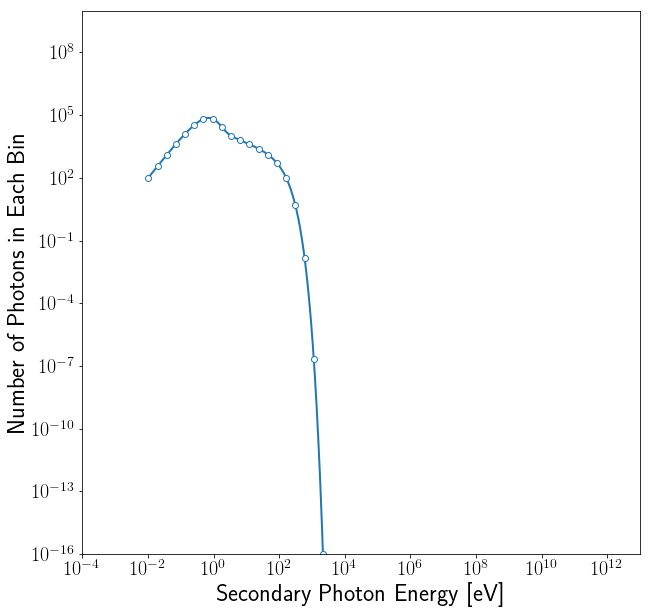

In [16]:
log_bin_width = spectools.get_log_bin_width(sec_phot_tf.get_eng())


ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([3.10456e6])

sec_phot_tf.plot(ax, ind=comp_elec_kineng, fac=log_bin_width*sec_phot_tf.get_eng(), indtype='in_eng', linewidth=2)

plt.gca().set_prop_cycle(None)

ICS_test_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=0, marker='o', markersize='6', 
    markerfacecolor='w', markevery=10,)
# sec_phot_tf.plot(ax, ind=145, fac=log_bin_width*sec_phot_tf.get_eng(), indtype='ind', linewidth=2)
# ICS_test_tf.plot(ax, ind=145, indtype='ind', linewidth=0, marker='o', markersize='6', 
#     markerfacecolor='w', markevery=10,)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Secondary Photon Energy [eV]',fontsize=24)

plt.ylabel('Number of Photons in Each Bin',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e10])

In [9]:
20918-10306

10612